In [53]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt

from lqmc.joint import GaussianCopula, GaussianCopulaAntiparallelCorrelated, GaussianCopulaParametrised
from lqmc.gp import RandomFeatureGaussianProcess
from lqmc.kernels import ExponentiatedQuadraticKernel
from lqmc.random import Seed
from lqmc.utils import to_tensor
from data.datasets import Wine


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
dataset = Wine(
    seed=[0, 0],
    split_id=0,
    num_splits=10,
    dtype=tf.float64,
)

KeyboardInterrupt: 

In [ ]:

joint_sampler = GaussianCopulaParametrised(
    seed=[0, 0],
    dim=dataset.dim,
    dtype=tf.float64,
    trainable=True,
)

In [ ]:
#@tf.function
def joint_sampler_gradient_step(
        seed: Seed,
        joint_sampler: GaussianCopula,
        kernel: ExponentiatedQuadraticKernel,
        x_train: tf.Tensor,
        optimizer: tf.keras.optimizers.Adam,
        num_ensembles: int = 1,
    ):
    with tf.GradientTape() as tape:
        seed, omega = joint_sampler(seed=seed, batch_size=num_ensembles)
        seed, loss = kernel.rmse_loss(seed=seed, omega=omega, x1=x_train, x2=x_train, num_ensembles=num_ensembles)
    gradients = tape.gradient(loss, joint_sampler.trainable_variables)
    optimizer.apply_gradients(zip(gradients, joint_sampler.trainable_variables))
    return seed, loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
kernel = ExponentiatedQuadraticKernel(
    dim=int(dataset.dim),
    lengthscales=dataset.dim*[1.0],
    output_scale=1.0,
    dtype=tf.float64,
)
seed = [0, 0]

for i in range(1000):

    seed, loss = joint_sampler_gradient_step(
        seed=seed,
        joint_sampler=joint_sampler,
        kernel=kernel,
        x_train=dataset.x_train,
        optimizer=optimizer,
        num_ensembles=1,
    )

    if i % 100 == 0:
        print(f"loss: {loss}")

loss: 0.16705955001522396


KeyboardInterrupt: 

In [ ]:
@tf.function
def rfgp_gradient_step(
        seed: Seed,
        rfgp: RandomFeatureGaussianProcess,
        optimizer: tf.keras.optimizers.Adam,
        num_ensembles: int = 1,
    ):
    with tf.GradientTape() as tape:
        seed, loss = rfgp.loss(seed=seed, num_ensembles=num_ensembles)
    gradients = tape.gradient(loss, rfgp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rfgp.trainable_variables))
    return seed, loss

seed = [0, 0]
kernel = ExponentiatedQuadraticKernel(
    dim=int(dataset.dim),
    lengthscales=dataset.dim*[1.0],
    output_scale=1.0,
    dtype=tf.float64,
)
rfgp = RandomFeatureGaussianProcess(
    kernel=kernel,
    noise_std=1.0,
    x=dataset.x_train,
    y=dataset.y_train[:, 0],
    joint_sampler=joint_sampler,
    dtype=tf.float64,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
seed = [0, 0]
losses = []

for i in range(10000):

    seed, loss = rfgp_gradient_step(
        seed=seed,
        rfgp=rfgp,
        optimizer=optimizer,
        num_ensembles=1,
    )
    losses.append(loss)

    if i % 1000 == 0:
        print(f"loss: {loss:.3f} {rfgp.noise_std.numpy():.3f} {rfgp.kernel.output_scale.numpy():.3f} {rfgp.kernel.lengthscales.numpy()}")

loss: 1.362 0.990 0.990 [1.01003439 1.01004775 1.01004972 1.01004858 1.01004638 1.01004723
 1.01004971 0.99005094 1.01004657 0.99005174 1.01004933 1.01004827
 1.01004936]
loss: 0.226 0.227 0.876 [ 2.44317787 35.55976928 16.1850777   7.95458202 10.9725577  19.2677039
  1.38889527 10.6960686  33.28150781  3.71743843  7.18382498  7.33122848
  3.07768097]
loss: 0.098 0.224 0.917 [ 2.27444149 78.11333891 16.21520477  7.3489469  50.17806706 41.49233486
  1.33826228 12.40331868 78.48458571  3.7979551  12.25694178  7.99807712
  3.14919659]
loss: 0.126 0.225 0.903 [  2.13921716 120.91751047  17.48416585   7.28791913  94.74663507
  71.78596625   1.36302267  10.67898068 125.90900346   3.56919712
  29.7719353    7.86024489   2.7553611 ]
loss: 0.157 0.220 0.932 [  2.22566753 179.72920578  17.30081949   7.92932688 146.21730033
 101.80703661   1.33851503  12.08605785 168.41070593   3.7357285
  59.51754427   6.06742063   3.05169222]
loss: 0.155 0.221 0.928 [  2.13015584 247.80952753  15.07950667   8.1

tf.Tensor(0.15651576428211114, shape=(), dtype=float64) tf.Tensor(0.0006689414219666796, shape=(), dtype=float64)


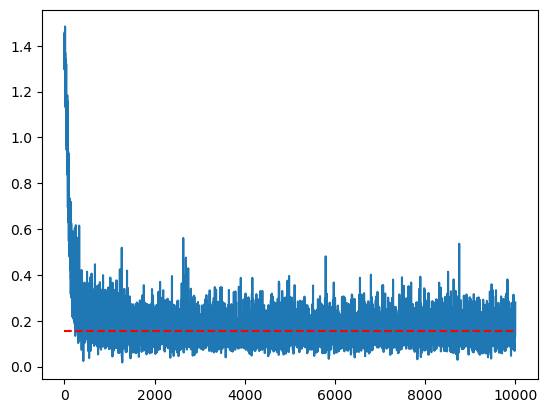

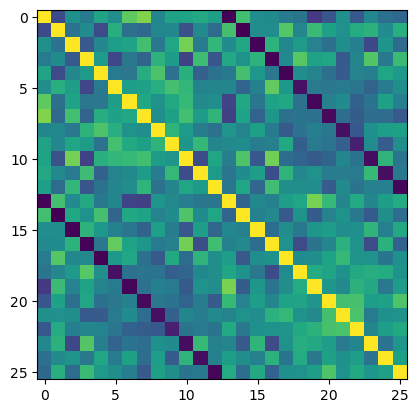

In [ ]:
plt.plot(losses)
plt.hlines(tf.reduce_mean(losses[4000:]), 0., len(losses), colors='r', linestyles='dashed')
print(tf.reduce_mean(losses[4000:]), tf.math.reduce_std(losses[4000:]) / 6000**0.5)
plt.show()
plt.imshow(rfgp.joint_sampler.covariance.numpy())
plt.show()

In [ ]:
joint_sampler = GaussianCopulaAntiparallelCorrelated(
    dim=dataset.dim,
    correlation_factor=0.,
    dtype=tf.float64,
)


@tf.function
def rfgp_gradient_step(
        seed: Seed,
        rfgp: RandomFeatureGaussianProcess,
        optimizer: tf.keras.optimizers.Adam,
        num_ensembles: int = 1,
    ):
    with tf.GradientTape() as tape:
        seed, loss = rfgp.loss(seed=seed, num_ensembles=num_ensembles)
    gradients = tape.gradient(loss, rfgp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rfgp.trainable_variables))
    return seed, loss

seed = [0, 0]
kernel = ExponentiatedQuadraticKernel(
    dim=int(dataset.dim),
    lengthscales=dataset.dim*[1.0],
    output_scale=1.0,
    dtype=tf.float64,
)
rfgp = RandomFeatureGaussianProcess(
    kernel=kernel,
    noise_std=1.0,
    x=dataset.x_train,
    y=dataset.y_train[:, 0],
    joint_sampler=joint_sampler,
    dtype=tf.float64,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
seed = [0, 0]
losses = []

for i in range(10000):

    seed, loss = rfgp_gradient_step(
        seed=seed,
        rfgp=rfgp,
        optimizer=optimizer,
        num_ensembles=1,
    )
    losses.append(loss)

    if i % 1000 == 0:
        print(f"loss: {loss:.3f} {rfgp.noise_std.numpy():.3f} {rfgp.kernel.output_scale.numpy():.3f} {rfgp.kernel.lengthscales.numpy()}")

loss: 1.369 0.990 0.990 [1.01003601 1.01004684 1.01004971 1.01004862 1.01004645 1.01004778
 1.01004973 0.99005098 1.01003783 0.99005218 1.01004929 1.01004867
 1.01004949]
loss: 0.226 0.231 0.881 [ 2.52003758 36.31469796 16.04965395  7.75499114 14.18464345 19.66889114
  1.39066338 10.69654007 33.72605195  3.86353332  7.97182248  7.38595789
  3.01767344]
loss: 0.114 0.226 0.949 [ 2.19845767 79.00864004 16.8431202   7.45689931 58.10599406 40.98646233
  1.38633108 12.29697876 79.41424722  3.62998257 21.02532598  8.01710872
  3.20419591]
loss: 0.131 0.225 0.917 [  2.24176196 124.54303119  18.66746249   7.33595979 110.22047466
  70.71960417   1.35797678  10.72436047 125.49779223   3.57683637
  46.50361873   7.89877089   2.75638322]
loss: 0.159 0.223 0.951 [  2.22320185 182.44067707  19.36644888   7.89778923 160.73993439
 101.02145498   1.37042482  11.66725852 170.94603946   4.08876389
  80.91657966   6.18659897   2.99833715]
loss: 0.113 0.222 0.970 [  2.12639277 256.90941324  16.31752482   8

tf.Tensor(0.16354896293430266, shape=(), dtype=float64) tf.Tensor(0.0006714056482936314, shape=(), dtype=float64)


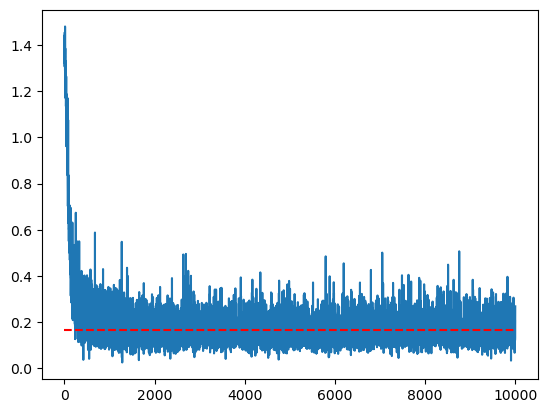

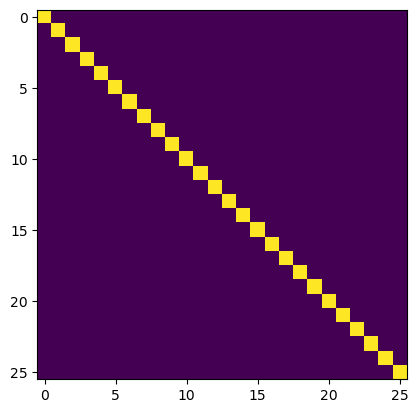

In [ ]:
plt.plot(losses)
plt.hlines(tf.reduce_mean(losses[4000:]), 0., len(losses), colors='r', linestyles='dashed')
print(tf.reduce_mean(losses[4000:]), tf.math.reduce_std(losses[4000:]) / 6000**0.5)
plt.show()
plt.imshow(rfgp.joint_sampler.covariance.numpy())
plt.show()

In [ ]:
rfgp.noise_std, kernel.output_scale, kernel.lengthscales

(<tf.Tensor: shape=(), dtype=float64, numpy=0.22431304140352226>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.912676400995032>,
 <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([2.10475053e+00, 2.06796190e+03, 1.59273085e+01, 7.64344225e+00,
        1.41594364e+03, 1.52012934e+03, 1.42611061e+00, 1.04353950e+01,
        1.37892532e+03, 3.57385997e+00, 5.90686387e+02, 7.14603587e+00,
        3.05445804e+00])>)

In [ ]:
tf.reduce_mean(dataset.y_train), tf.math.reduce_std(dataset.y_train)

(<tf.Tensor: shape=(), dtype=float64, numpy=3.8616453030440226e-17>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.0>)

In [ ]:
tf.reduce_mean(dataset.y_test), tf.math.reduce_std(dataset.y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.08836552891871442>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9919541791966401>)

In [ ]:
_, pred_mean, pred_cov = rfgp(seed=seed, x_pred=dataset.x_test, num_ensembles=10, noiseless=False)

In [ ]:
# Compute RMSE
rmse = tf.math.sqrt(tf.reduce_mean((pred_mean - dataset.y_test[:, 0])**2))
print(rmse)

tf.Tensor(0.21072946557225744, shape=(), dtype=float64)


In [ ]:
pred_mean.shape, dataset.y_test.shape

(TensorShape([17]), TensorShape([17, 1]))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

In [ ]:
samples = tfp.mcmc.sample_halton_sequence(
    dim=2,
    num_results=10,
    sequence_indices=None,
    dtype=tf.float32,
    randomized=False,
    seed=None,
    name=None
)

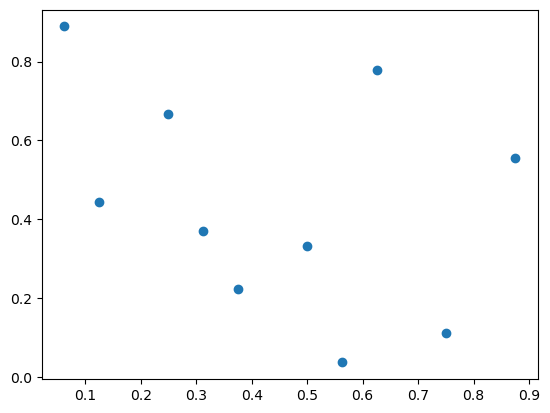

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1])

In [ ]:
from lqmc.random import rand_halton

seed, samples = rand_halton(
    dim=2,
    num_samples=10,
    shape=(),
    dtype=tf.float32,
    seed=seed,
)

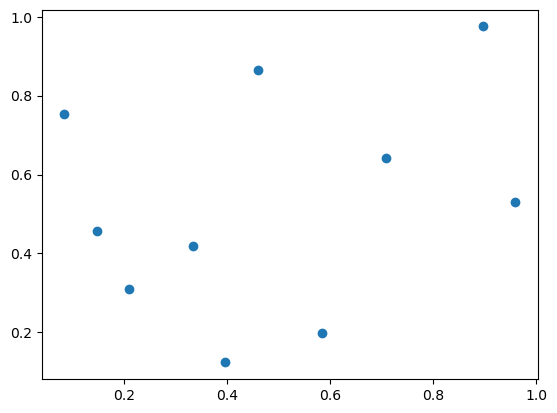

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

In [4]:
%load_ext autoreload
%autoreload 2

import argparse

import tensorflow as tf

from lqmc.joint import (
    IndependentUniform,
    HaltonSequence,
    GaussianCopulaAntiparallelCorrelated,
    GaussianCopulaAntiparallelAnticorrelated,
    GaussianCopulaParametrised,
)

from lqmc.gp import GaussianProcess, RandomFeatureGaussianProcess
from lqmc.kernels import ExponentiatedQuadraticKernel
from data.datasets import make_dataset


DTYPE = tf.float64



#@tf.function
def gradient_step(optimizer: tf.keras.optimizers.Optimizer, model: tf.keras.Model):
    
    with tf.GradientTape() as tape:
        loss = model.loss()
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


def main():

    # Dataset arguments
    args_dataset = "wine"
    args_seed_dataset = 0
    args_num_splits = 5
    args_split_id = 0
    args_max_datapoints = 512

    # Kernel arguments
    args_lengthscale = 1.
    args_output_scale = 1.

    # Exact GP arguments
    args_noise_std = 1.

    # Training arguments
    args_seed_training = 1
    args_num_steps = 10
    args_learning_rate = 1e-1


    # Create dataset
    dataset = make_dataset(
        name=args_dataset,
        seed=[args_seed_dataset, args_seed_dataset],
        num_splits=args_num_splits,
        split_id=args_split_id,
        max_datapoints=args_max_datapoints,
        dtype=DTYPE,
    )

    # Create kernel
    kernel = ExponentiatedQuadraticKernel(
        lengthscales=dataset.dim * [args_lengthscale],
        output_scale=args_output_scale,
        dim=dataset.dim,
        dtype=DTYPE,
    )

    # Create GP
    gp = GaussianProcess(
        kernel=kernel,
        noise_std=args_noise_std,
        x=dataset.x_train,
        y=dataset.y_train,
        dtype=DTYPE,
    )

    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=args_learning_rate)

    # Train GP hyperparameters
    for i in range(args_num_steps):

        loss = gradient_step(optimizer, gp)
        if i % 1 == 0:
            print(loss)

main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(1.4172265638492032, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(1.3208448661531034, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(1.2196297388757726, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(1.1148858534035881, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(1.0084123154659441, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(0.9023296708583158, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(0.7989943184051703, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(0.7008382685945554, shape=(), dtype=float64)
(143, 13) (143, 13) (1, 1, 13)
(143, 143, 13)
tf.Tensor(0.6098216009804355, shape=(), dtype=float64)
(14